# Linear Inverted Pendulum with Wall, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [2]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import HybridModelPredictiveController
from pympc.approximated_controller import ApproximatedHybridModelPredictiveController, FeasibleSetLibrary, upload_FeasibleSetLibrary
from pympc.geometry.polytope import Polytope

# Dynamics

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$. The pendulum is allowed to impact with an elastic wall (with stiffness $k$) placed at distance $d$ from the vertical line passing trough the hinge.

In [4]:
m = 1.
l = 1.
g = 10.
k = 1000.
d = .1
t_s = .01

We express the linearized dynamics in PieceWise Affine (PWA) form:
\begin{equation}
\dot x =
\begin{cases}
A_1 x + B_1 u + c_1, \quad \text{if} \quad (x, u) \in \mathcal D_1, \\
A_2 x + B_2 u + c_2, \quad \text{if} \quad (x, u) \in \mathcal D_2,
\end{cases}
\end{equation}

with

\begin{equation}
A_1 = 
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix},
\quad
B_1 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_1 = 
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_1 =
\{ (x,u) \ | \ x_1 \leq d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}

\begin{equation}
A_2 = 
\begin{bmatrix}
0 & 1 \\ g/l - k/m & 0
\end{bmatrix},
\quad
B_2 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_2 = 
\begin{bmatrix}
0 \\ kd/(ml)
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_2 =
\{ (x,u) \ | \ x_1 > d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}


The discrete-time PWA system can be defined from its continuous-time representation setting a sampling time $t_s$.

In [5]:
# discretization method
method = 'explicit_euler'

# dynamics n.1
A_1 = np.array([[0., 1.],[g/l, 0.]])
B_1 = np.array([[0.],[1/(m*l**2.)]])
c_1 = np.array([[0.],[0.]])
S_1 = ds.AffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# dynamics n.2
A_2 = np.array([[0., 1.],[g/l-k/m, 0.]])
B_2 = B_1
c_2 = np.array([[0.],[k*d/(m*l)]])
S_2 = ds.AffineSystem.from_continuous(A_2, B_2, c_2, t_s, method)

# list of dynamics
S = [S_1, S_2]

The domains of the PWA have to be expressed as polytopes.

In [6]:
# state domain n.1
x_max_1 = np.array([[d/l], [1.]])
x_min_1 = -np.array([[d/l*1.2],[x_max_1[1,0]]])
X_1 = Polytope.from_bounds(x_min_1, x_max_1)
X_1.assemble()

# state domain n.2
x_min_2 = np.array([[x_max_1[0,0]], [x_min_1[1,0]]])
x_max_2 = -x_min_1
X_2 = Polytope.from_bounds(x_min_2, x_max_2)
X_2.assemble()

# list of state domains
X = [X_1, X_2]

# input domain
u_max = np.array([[4.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*2

We can now define the PWA system.

In [7]:
pwa_sys = ds.PieceWiseAffineSystem.from_orthogonal_domains(S, X, U)

# MPC controller

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad &
x_{k+1} =
\begin{cases}
A_1 x_k + B_1 u_k + c_1, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_1, \\
A_2 x_k + B_2 u_k + c_2, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_2,
\end{cases}, \\
& (x_k, u_k) \in \mathcal D_1 \cup \mathcal D_2, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [8]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[0].A, S[0].B, Q, R)
X_N = ds.moas_closed_loop_from_orthogonal_domains(S[0].A, S[0].B, K, X[0], U[0])

# hybrid controller
gurobi_parameters = {'OutputFlag': False}
controller = HybridModelPredictiveController(pwa_sys, N, objective_norm, Q, R, P, X_N, gurobi_parameters)

Computation of Maximal Invariant Constraint-Admissible Set started.
Determinedness index: 23, Convergence index: -8.2567687914e-05, Number of facets: 120.                
Maximal Invariant Constraint-Admissible Set found.
Removing redundant facets ... minimal facets are 45.


We can now simulate the closed-loop dynamics startion from the initial state $x_0$.

In [9]:
N_sim = 100
x_0 = np.array([[.05],[.52]])
u = []
x = [x_0]
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u.append(controller.feedback(x[k]))
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system.

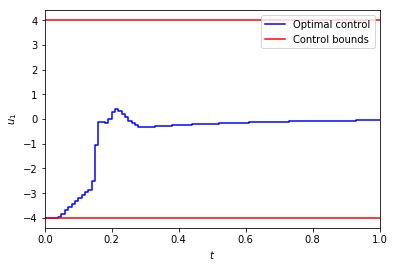

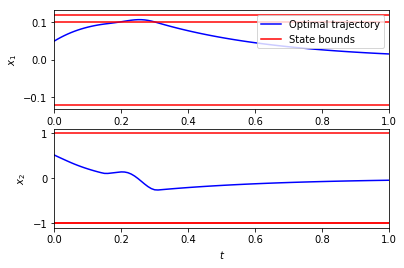

In [10]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()

# Approximate MPC controller

Construction of the library

In [14]:
terminal_mode = 0

In [15]:
n_samples = 10000
library = FeasibleSetLibrary(controller)
library.sample_policy(n_samples)
library.store_halfspaces()
#library.save('library_pendulum_' + str(n_samples))

Sample 0: 
solving MIQP...  time spent: 0.00148105621338 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 1: 
solving MIQP...  time spent: 0.00549292564392 s, model status: OPTIMAL.
new mode sequence (0, 0, 0, 0, 0, 0, 0, 0, 0, 0).
condensing QP...  QP condensed in 0.0042359828949 s.
building inner approximation...  approximation built 0.0909309387207 s.
Sample 2: 
solving MIQP...  time spent: 0.00244188308716 s, model status: OPTIMAL.
included.
including sample in inner approximation...  sample included in 0.0267899036407 s.
Sample 3: 
solving MIQP...  time spent: 0.00499892234802 s, model status: OPTIMAL.
new mode sequence (1, 1, 1, 0, 0, 0, 0, 0, 0, 0).
condensing QP...  QP condensed in 0.00190091133118 s.
building inner approximation...  approximation built 0.0969290733337 s.
Sample 4: 
solving MIQP...  time spent: 0.000949859619141 s, model status: INFEASIBLE OR UNBOUNDED.
Sample 5: 
solving MIQP...  time spent: 0.00429320335388 s, model status: OPTIMAL.
included.
including sample

In [17]:
from pympc.mode_sequence_tree import plot_mode_sequence_tree
plot_mode_sequence_tree(library.mode_sequences.keys())

strict digraph "" {
	graph [label="Mode Sequence Tree"];
	node [label="\N"];
	"(0,)"	 [label=0];
	"(0, 0)"	 [label=0];
	"(0,)" -> "(0, 0)"	 [color=blue];
	"(0, 1)"	 [label=1];
	"(0,)" -> "(0, 1)"	 [color=blue];
	"(0, 0, 0)"	 [label=0];
	"(0, 0)" -> "(0, 0, 0)"	 [color=blue];
	"(0, 0, 1)"	 [label=1];
	"(0, 0)" -> "(0, 0, 1)"	 [color=blue];
	"(0, 1, 1)"	 [label=1];
	"(0, 1)" -> "(0, 1, 1)"	 [color=blue];
	"(0, 0, 0, 1)"	 [label=1];
	"(0, 0, 0)" -> "(0, 0, 0, 1)"	 [color=blue];
	"(0, 0, 0, 0)"	 [label=0];
	"(0, 0, 0)" -> "(0, 0, 0, 0)"	 [color=blue];
	"(0, 0, 1, 1)"	 [label=1];
	"(0, 0, 1)" -> "(0, 0, 1, 1)"	 [color=blue];
	"(0, 0, 0, 1, 1)"	 [label=1];
	"(0, 0, 0, 1)" -> "(0, 0, 0, 1, 1)"	 [color=blue];
	"(0, 0, 0, 0, 0)"	 [label=0];
	"(0, 0, 0, 0)" -> "(0, 0, 0, 0, 0)"	 [color=blue];
	"(0, 0, 0, 1, 1, 1)"	 [label=1];
	"(0, 0, 0, 1, 1)" -> "(0, 0, 0, 1, 1, 1)"	 [color=blue];
	"(0, 0, 0, 1, 1, 1, 1)"	 [label=1];
	"(0, 0, 0, 1, 1, 1)" -> "(0, 0, 0, 1, 1, 1, 1)"	 [color=blue];
	"(0, 0, 0, 1

In [ ]:
library = upload_FeasibleSetLibrary('library_pendulum_' + str(n_samples))

In [ ]:
approximated_controller = ApproximatedHybridModelPredictiveController(library, terminal_mode)

Plot feasible sets

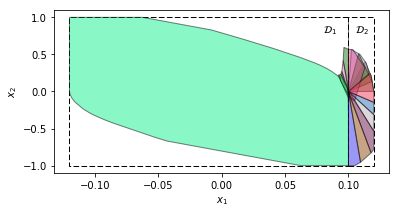

In [34]:
fig = plt.figure(figsize=(6,3))
X_1.plot(facecolor='w', linestyle='--')
plt.text(.08,.8,r'$\mathcal{D}_1$')
X_2.plot(facecolor='w', linestyle='--')
plt.text(.105,.8,r'$\mathcal{D}_2$')
library.plot_partition()
fig.savefig('sample_pendulum.pdf', bbox_inches='tight')
plt.show()

Simulate closed loop system

In [ ]:
u = []
x = [x_0]
ms = []
ms_feasible = None
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u_k, ms_k = approximated_controller.feedback(x[k], ms_feasible)
    u.append(u_k)
    x.append(pwa_sys.simulate(x[k], [u_k])[0][1])
    ms.append(ms_k)
    ms_feasible = ms_k[1:] + (terminal_mode,)

In [ ]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()

# Enumeration of feasible mode sequences

Construct all the possible 2^N modes

In [ ]:
from itertools import product
modes = [[0,1]]*controller.N
ms_list = product(*modes)
ms_list = [ma for ma in ms_list]

Derive the feasible set for each mode sequence

In [ ]:
n_feasible = 2**controller.N
errors = 0
n = 0
p_list = []
for i, ms in enumerate(ms_list):
    print i, ms
    prog = controller.condense_program(ms)
    try:
        if prog.feasible_set is None:
            n_feasible -= 1
        else:
            p_list.append(prog.feasible_set)
            n += 1
    except:
        errors += 1

Plot the partition

In [ ]:
fig = plt.figure(figsize=(6,3))
X_1.plot(facecolor='w', linestyle='--')
plt.text(.08,.8,r'$\mathcal{D}_1$')
X_2.plot(facecolor='w', linestyle='--')
plt.text(.105,.8,r'$\mathcal{D}_2$')
for i,p in enumerate(p_list):
    color = np.random.rand(3,1)
    p.plot(facecolor=color, alpha=.5)
#fig.savefig("all_feasible_mode_sequences.pdf", bbox_inches='tight')
plt.show()

Sample for the highest number of overlapping regions

In [ ]:
n_samples = 10000
x_min = np.array([[.07],[-.4]])
x_max = np.array([[.12],[.5]])
max_overlapping_regions(p_list, n_samples, x_min, x_max)

# Fancy plot for the paper

In [ ]:
N_sim = 200
fig = plt.figure(figsize=(6,3))

# fake plots for the legend
plt.scatter(0,0, color='w', edgecolor='k', label='Initial conditions')
plt.scatter(0,0, color='r', edgecolor='k', label='Equilibrium point')
plt.plot([0,0],[0,0], color=np.array([.3,.3,1.]), linestyle='--', label='Approximate hybrid MPC')
plt.plot([0,0],[0,0], color=np.array([.3,1.,.3]), label='Exact hybrid MPC')

# plots of the domains
plt.plot([.1,.1],[-.6,.4], color='k', linestyle='--')
plt.text(.09,.35,r'$\mathcal{D}_1$')
plt.text(.105,.35,r'$\mathcal{D}_2$')

# plot of the trajectories
x1 = .095
for j, x2 in enumerate(np.linspace(-.5,.5,21)):
    print j
    x_0 = np.array([[x1],[x2]])
    # plot exact mpc
    u = []
    x = [x_0]
    feasible = True
    for k in range(N_sim):
        u.append(controller.feedback(x[k]))
        if np.isnan(np.linalg.norm(u[k])):
            feasible = False
            break
        x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
        x.append(x_next)
    if feasible:
        mpc_plt.state_space_trajectory(x, color=np.array([.3,1.,.3]))
    # plot approximate mpc   
    u = []
    x = [x_0]
    ss = []
    ss_feasible = None
    feasible = True
    for k in range(N_sim):
        u_k, ss_k = library.feedback(x[k], ss_feasible)
        if np.isnan(np.linalg.norm(u_k)):
            feasible = False
            break
        u.append(u_k)
        x.append(pwa_sys.simulate(x[k], [u_k])[0][1])
        ss.append(ss_k)
        ss_feasible = ss_k[1:] + (terminal_mode,)
    if feasible:
        mpc_plt.state_space_trajectory(x, color=np.array([.3,.3,1.]), linestyle=':')
plt.legend(loc=9)
#fig.savefig("trajectories_pendulum.pdf", bbox_inches='tight')
plt.show()